## 필요한 데이터세트

In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import itertools
import json

In [2]:
data_path = "/home/ai-sjjy/workspace/juyoung/JasoseoAI_project/3.data/Keyword/"
src_path = "/home/ai-sjjy/workspace/juyoung/JasoseoAI_project/2.src/Keyword_AI/"

In [3]:
with open(data_path+'CompanyKeywordData_Preprocess.json', 'r', encoding='utf-8') as f: # 회사-[질문:답변] => dict 형식
    dataset = json.load(f)

In [4]:
with open(data_path+'KeywordCategory.pickle', 'rb') as f:
    keywords = pickle.load(f)

In [5]:
keywords

['정직',
 '전문성',
 '봉사',
 '실행',
 '자율성',
 '진취',
 '긍정',
 '자기주도',
 '기본기',
 '고객',
 '안전',
 '개방',
 '공감',
 '헌신',
 '사회적 가치',
 '글로벌',
 '리더쉽',
 '열정',
 '신뢰',
 '책임감',
 '자연친화',
 '변화',
 '성장',
 '인간미',
 '친절',
 '팀워크',
 '문제해결',
 '효율',
 '자신감',
 '다양성',
 '창의성',
 '도전',
 '공정',
 '상생',
 '존중',
 '배려',
 '자기개발',
 '윤리성',
 '학습',
 '유연성',
 '자부심',
 '소통',
 '성실',
 '끈기',
 '혁신',
 '미래']

## 데이터 셋 준비 과정

In [6]:
train_sentences = []
label_sentences = []
for key, value in dataset.items():
    preprocess = value['preprocess']
    keywords = value['keywords']
    for pre in preprocess:
        if not pre: continue # null drop!
        else:
            train_sentences.append(pre)
            label_sentences.append(keywords)

In [7]:
len(train_sentences)

6800

#### [1] label 분포 확인

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=10)

In [9]:
label_sentences[1000]

['혁신', '글로벌', '정직', '책임감', '창의성']

In [10]:
label_nums = dict()

for labels in label_sentences:
    for label in labels:
        if label not in label_nums.keys(): label_nums[label] = 1
        else: label_nums[label] += 1

* 자연친화, 자율성, 효율, 친절 => 개수 적음

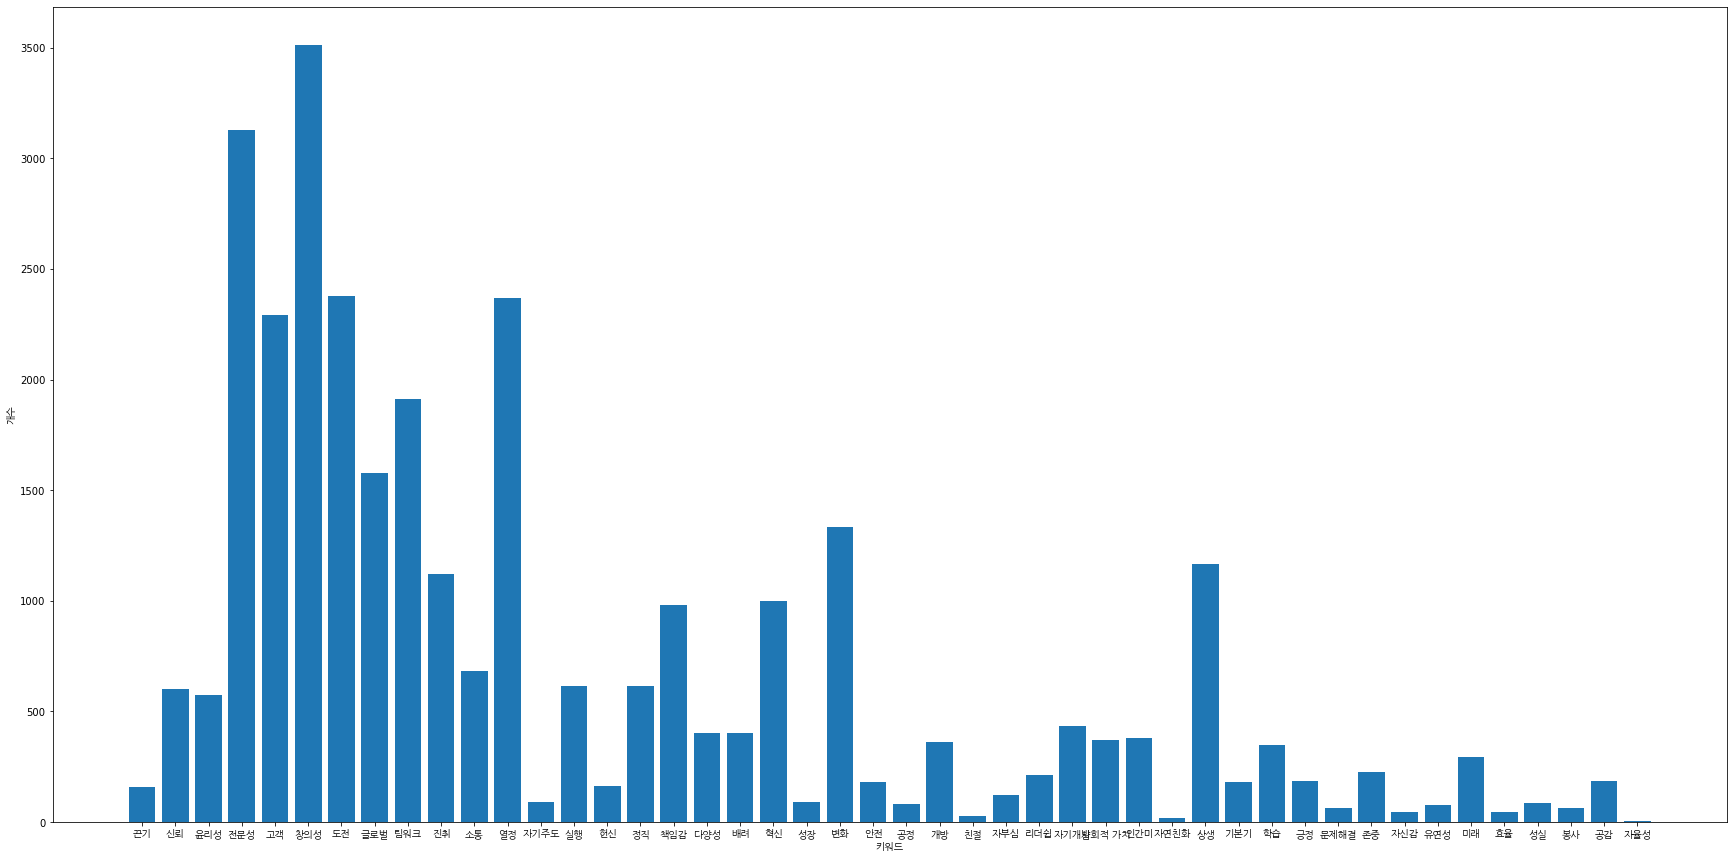

In [11]:
plt.figure(figsize=(30, 15))
plt.bar(label_nums.keys(), label_nums.values())
plt.xticks(fontproperties=fontprop)
plt.xlabel("키워드", fontproperties=fontprop)
plt.ylabel("개수", fontproperties=fontprop)
plt.show()

#### [2] content안 단어 개수 분포 확인

In [12]:
sentences_nums = []

for sentences in train_sentences:
    sentences_nums.append(len(sentences))

In [13]:
from collections import Counter

sentences_nums = Counter(sentences_nums)

* 그래프에서 보다 싶이 보통 150 미만 인듭

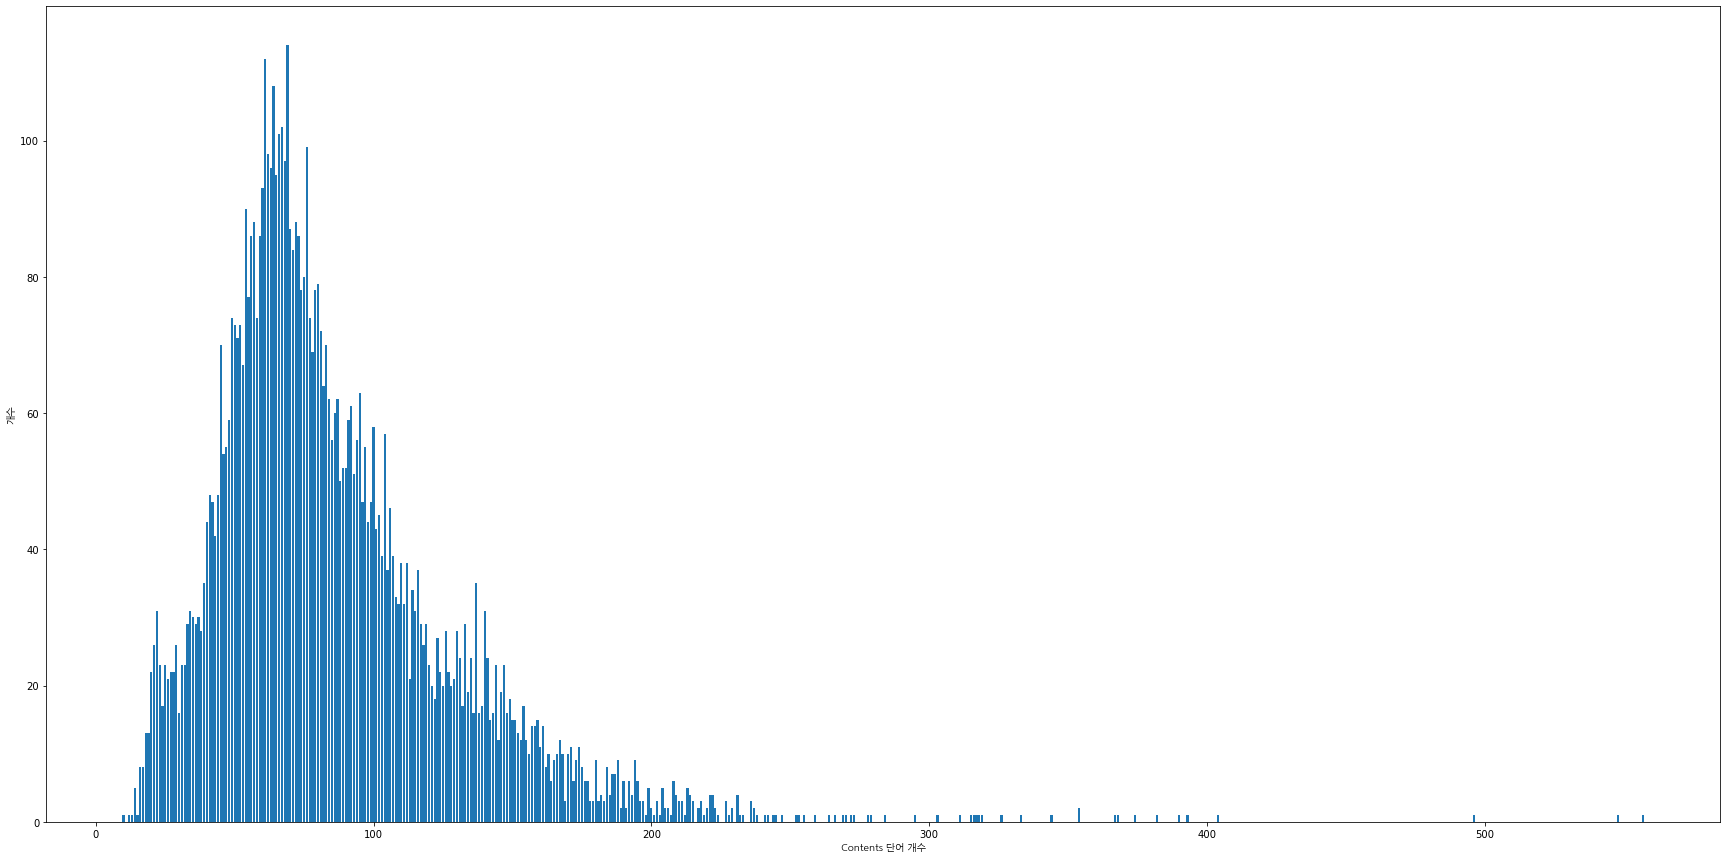

In [14]:
plt.figure(figsize=(30, 15))
plt.bar(sentences_nums.keys(), sentences_nums.values())
plt.xlabel("Contents 단어 개수", fontproperties=fontprop)
plt.ylabel("개수", fontproperties=fontprop)
plt.show()

In [15]:
print("Average # of words: {}".format(sum(sentences_nums)/len(sentences_nums)))

Average # of words: 152.06870229007635


### (1) Tokenizer

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

max_nb_words = len(tokenizer.word_index)+1

In [18]:
max_nb_words

16127

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [20]:
# y -> multi-label 진행
labels = mlb.fit_transform(label_sentences)

In [21]:
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

1. 개방
2. 고객
3. 공감
4. 공정
5. 글로벌
6. 긍정
7. 기본기
8. 끈기
9. 다양성
10. 도전
11. 리더쉽
12. 문제해결
13. 미래
14. 배려
15. 변화
16. 봉사
17. 사회적 가치
18. 상생
19. 성실
20. 성장
21. 소통
22. 신뢰
23. 실행
24. 안전
25. 열정
26. 유연성
27. 윤리성
28. 인간미
29. 자기개발
30. 자기주도
31. 자부심
32. 자신감
33. 자연친화
34. 자율성
35. 전문성
36. 정직
37. 존중
38. 진취
39. 창의성
40. 책임감
41. 친절
42. 팀워크
43. 학습
44. 헌신
45. 혁신
46. 효율


In [22]:
labels[:3]

array([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [23]:
len(labels[0])

46

### (2) 평균 문장으로 x_train 맞추기 + Multi-labeling

In [24]:
MAX_SENTENCE_LEN = 150

In [25]:
def build_dataset(x_data, max_sentence_length=MAX_SENTENCE_LEN, tok=tokenizer): # 이미 토크나이저 진행!
    # x -> train data 생성
    sequences = tok.texts_to_sequences(x_data)
    X_data = pad_sequences(sequences, maxlen=max_sentence_length)
    return X_data

In [26]:
train_X_data, train_Y_data = build_dataset(train_sentences), labels

In [27]:
print(train_X_data.shape)
print(train_Y_data.shape)

(6800, 150)
(6800, 46)


### (3) train, test split

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X_data, train_Y_data, test_size=0.1)

In [29]:
print("X_train.shape: {}".format(X_train.shape))
print("y_train.shape: {}".format(y_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_test.shape: {}".format(y_test.shape))

X_train.shape: (6120, 150)
y_train.shape: (6120, 46)
X_test.shape: (680, 150)
y_test.shape: (680, 46)


## Word2vec 임베딩 로드

In [30]:
import tensorflow as tf

In [31]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 첫 번째 GPU만 사용하도록 제한
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

#### (1) word2vec load해서 임베딩 벡터로 사용

In [32]:
from gensim.models import KeyedVectors

embeddings_index = KeyedVectors.load(src_path+'word2vec_pre-model/ko_new.bin')

In [33]:
def load_embedding(tok = tokenizer, embedding_dim=100):
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [34]:
embedding_matrix = load_embedding()

<ipython-input-33-f5eb5471813f>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vector = embeddings_index[word]


In [35]:
print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

embedding_matrix.shape: (16127, 100)


## 모델 구성

In [36]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.python.keras.layers import Layer, InputSpec
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Embedding, Dense
from tensorflow.python.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.python.keras.layers import Bidirectional, TimeDistributed
from tensorflow.python.keras.layers import GRU
from tensorflow.python.keras.layers import BatchNormalization, Dropout
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import SGD

In [37]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # u_it => bidirection gru(현재 시점 hidden state)값 feed foward network에 입력으로 넣어 u_it벡터 얻음
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        # 단어 문맥 벡터 self.u랑 u_it랑 유사도(내적) 구함 => attention score 구함
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        # softmax 취해서 attention distribution 구함
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape): ###...?
        return (input_shape[0], input_shape[1])

In [38]:
def WeightedSum(attentions, representations): # 입력 (attention_distribution, hidden state)
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation

In [39]:
def wordAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=100,
           attention_dim=200, # 문맥벡터 사이즈 => 양방향 gru 100+100 해서 200
           rnn_dim=100, # gru 사이즈
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)): # Stochastic Gradient Descent(논문은)
    
    # embedding matrix => (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)
    # (1) word encoder => sentence
    sentence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
      # (1-1) word embedding -> bidirectional gru에 들어감
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence)
    
    # word attention 계산 -> attention distribution 추출
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)
    
    # WeightedSum -> 가중합 (word_attention, contextualized_sentence) => (attention, hiddenstate) 가중 합 해서
    # context vector(sentence_representation)를 얻는다
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)
    
    # classification을 위한 부분
    fc_layers = Sequential()
    
    # softmax하기 전에 먼저 fully로 들어감
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    # 마지막은 n개의 노드를 만들어줌 => 이때 다중 분류니까 activation function은 sigmoid
    fc_layers.add(Dense(nb_classes, activation='sigmoid'))
    
    pred_sentiment = fc_layers(sentence_representation)
    
    # model 정의
    model = Model(inputs=[sentence_input], outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input], outputs=[word_attention])
    model.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=["accuracy"])
    
    
    return model, word_attention_extractor

In [40]:
model_name = "WordAttn"

model_path = src_path + './models/checkpoints/{}.h5'.format(model_name)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,monitor='val_acc', 
                                                  verbose=True,save_best_only=True,mode='max')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# 모델 구성
model, attention_extractor = wordAtt(
    embedding_matrix=embedding_matrix,
    max_sentence_length=MAX_SENTENCE_LEN,
    nb_classes=len(labels[0]), # 46개
    embedding_dim=100,
    attention_dim=200,
    rnn_dim=100,
    include_dense_batch_normalization=False,
    include_dense_dropout=True,
    nb_dense=1,
    dense_dim=200,
    dense_dropout=0.2,
    optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #keras.optimizers.Adam(lr=0.001)
)

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 100)     1612700     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 150, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 150, 200)     120600      dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=60,
                    verbose=True,
                    validation_split=0.1, 
                    callbacks=[checkpointer,callback]
)

Epoch 1/60
87/87 [==============================] - 54s 567ms/step - loss: 0.5903 - accuracy: 0.0135 - val_loss: 0.2832 - val_accuracy: 0.0098
Epoch 2/60
87/87 [==============================] - 34s 386ms/step - loss: 0.2913 - accuracy: 0.0309 - val_loss: 0.2751 - val_accuracy: 0.0082
Epoch 3/60
87/87 [==============================] - 28s 325ms/step - loss: 0.2844 - accuracy: 0.0267 - val_loss: 0.2709 - val_accuracy: 0.0033
Epoch 4/60
87/87 [==============================] - 27s 307ms/step - loss: 0.2784 - accuracy: 0.0270 - val_loss: 0.2666 - val_accuracy: 0.0016
Epoch 5/60
87/87 [==============================] - 46s 527ms/step - loss: 0.2737 - accuracy: 0.0199 - val_loss: 0.2633 - val_accuracy: 0.0000e+00
Epoch 6/60
35/87 [===========>..................] - ETA: 54s - loss: 0.2682 - accuracy: 0.0177

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')